In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp
import numpy as onp
import pymdp.jax
from fast_structure_learning import *

In [3]:
file_name = "2.npz"
path = "../../../data/walker/run/"

res = onp.load(path + file_name)

In [4]:
res["observation"].shape

(501, 3, 64, 64)

In [5]:
!pip install -q mediapy


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


walker

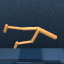

In [6]:
import mediapy

ims = [onp.transpose(res["observation"][i], (1, 2, 0)) for i in range(res["observation"].shape[0])]

with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"walker": ims}, width=320, height=320, fps=20, codec='gif')

In [8]:
res["action"].shape

(501, 6)

In [9]:
res["action"][60]

array([-0.9000735 ,  0.92900676,  0.98730826,  0.9593008 , -0.8928647 ,
        1.        ], dtype=float32)

In [10]:
frames = onp.transpose(res["observation"], (0, 2, 3, 1))

In [11]:
num_frames = 128
offset = 64

frames = frames[offset:offset + num_frames]

In [12]:
frames.shape

(128, 64, 64, 3)

walker

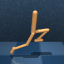

In [13]:
mediapy.show_videos({"walker": [frames[i] for i in range(frames.shape[0])]}, width=320, height=320, fps=20, codec='gif')

In [15]:
import pymdp.jax
from fast_structure_learning import *

(observations, locations_matrix, group_indices, sv_discrete_axis, V_per_patch), patch_indices = map_rgb_2_discrete(frames, tile_diameter=16, n_bins=9, sv_thr=1.0/32)
agents, RG, LB = spm_mb_structure_learning(observations, locations_matrix, max_levels=8)

Maximum probability state about factor 0 at time 0: 56
Maximum probability state about factor 0 at time 1: 27
Maximum probability state about factor 0 at time 2: 37
Maximum probability state about factor 0 at time 3: 36
Maximum probability state about factor 0 at time 4: 1
Maximum probability state about factor 0 at time 5: 0
Maximum probability state about factor 0 at time 6: 35
Maximum probability state about factor 0 at time 7: 39
Maximum probability state about factor 0 at time 8: 33
Maximum probability state about factor 0 at time 9: 38
Maximum probability state about factor 0 at time 10: 41
Maximum probability state about factor 0 at time 11: 52
Maximum probability state about factor 0 at time 12: 29
Maximum probability state about factor 0 at time 13: 40
Maximum probability state about factor 0 at time 14: 57
Maximum probability state about factor 0 at time 15: 46
Maximum probability state about factor 0 at time 16: 44
Maximum probability state about factor 0 at time 17: 47
Maxi

In [16]:
def to_img(img):
    im = jnp.transpose(img, (1, 2, 0))
    im /= 255
    im = jnp.clip(im, 0, 1)
    im = (255*im).astype(onp.uint8)
    return im

generations

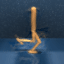

In [17]:
# generate n step predictions
one_hot = jnp.zeros([1, 32])
one_hot = one_hot.at[0, 0].set(1.0)
D = [one_hot]
E = jnp.array([[0]])
observations, beliefs = predict(agents, D, E, num_steps=64)

# convert to images
obs = jnp.array(observations[0])
map_discrete_2_rgb_fn = partial(map_discrete_2_rgb, locations_matrix=locations_matrix, group_indices=group_indices, sv_discrete_axis=sv_discrete_axis, V_per_patch=V_per_patch, patch_indices=patch_indices, image_shape=frames.shape[-3:])
imgs = vmap(map_discrete_2_rgb_fn, in_axes=1, out_axes=0)(obs)
imgs = imgs.reshape((imgs.shape[0]*imgs.shape[1], imgs.shape[-3], imgs.shape[-2], imgs.shape[-1]))

ims = [to_img(imgs[i]) for i in range(imgs.shape[0])]
with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"generations": ims}, width=320, height=320, fps=20, codec='gif')

In [18]:
obs.shape

(273, 130, 9)

In [19]:
sum(obs[0, :, :])

Array([14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [20]:
all_frames = onp.transpose(res["observation"], (0, 2, 3, 1))

In [22]:
(observations, locations_matrix, group_indices, sv_discrete_axis, V_per_patch), patch_indices = map_rgb_2_discrete(all_frames, tile_diameter=16, n_bins=9, V_per_patch=V_per_patch, sv_discrete_axis=sv_discrete_axis)

reconstructions

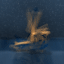

In [23]:
imgs = vmap(map_discrete_2_rgb_fn, in_axes=1, out_axes=0)(observations)
imgs = imgs.reshape((imgs.shape[0] * imgs.shape[1], imgs.shape[-3], imgs.shape[-2], imgs.shape[-1]))

ims = [to_img(imgs[i]) for i in range(imgs.shape[0])]
with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"reconstructions": ims}, width=320, height=320, fps=20, codec="gif")